# LightGBM Regressor
The goal of this script is to document the generic steps in hyper parameter tuning and training a Light GBM model.
This can be used to produce a baseline model to compare to, but in practice, more modifications will be necessary for fine tuning and creating the best possible model.

#### Useful Resources:
 - Source Documentation: https://lightgbm.readthedocs.io/en/latest/
 - Source Documentation (Hyperparameters): https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
 - In Depth Analysis of Important Hyperparameters: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


In [1]:
##### Imports #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import pickle
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# reduce_memory_usage optimizes the amount of memory required for each column. Pandas defaults to 64 bit data types, but this is wasteful.
# This function looks at the range of values and assigns the most optimal type that keeps the data in tact

# Source for this code: https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Read in data and run reduce memory function
# SIMPLE TEST EXAMPLE USING CALIFORNIA HOUSING DATASET
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
data = pd.DataFrame(housing.data)
data.columns = housing.feature_names
data['MedHouseVal'] = housing.target
reduced_df = reduce_memory_usage(data)
X, y = reduced_df.loc[:,reduced_df.columns != 'MedHouseVal'], reduced_df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1) 

Memory usage of dataframe is 1.42 MB
Memory usage after optimization is: 1.30 MB
Decreased by 8.3%


In [4]:
def LightGBM_Regressor_Training (lgbr_params, scoring_param, X_train, X_test, y_train, y_test):
    # Parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    
    # Perform GridSearch
    start_time = time.time()
    grid = GridSearchCV(lgb.LGBMRegressor(random_state=1), lgbr_params, scoring = scoring_param, cv=2, n_jobs=-1, verbose=True)
    grid.fit(X_train, y_train)
    
    # Report Results
    print('\nGrid Search Completed in:', round(time.time() - start_time,0),'seconds')
    print('Grid Search Best Hyper Parameters:', grid.best_params_)
    
    # Create predictions on test dataset
    lgbr_tuned = grid.best_estimator_
    lgbr_preds = lgbr_tuned.predict(X_test)
    
    # Store error metrics
    lgbr_error_metrics = {'mae':0,'rmse':0,'mse':0,'r2':0,'adjusted_r2':0}
    lgbr_error_metrics['mse'] = mean_squared_error(y_test, lgbr_preds)
    lgbr_error_metrics['rmse'] = np.sqrt(lgbr_error_metrics['mse'])
    lgbr_error_metrics['mae'] = mean_absolute_error(y_test, lgbr_preds)
    lgbr_error_metrics['r2'] = r2_score(y_test,lgbr_preds)
    n = y_test.shape[0] # Number of rows
    k = len(X_test.columns) # Number of independent variables
    lgbr_error_metrics['adjusted_r2'] = 1 - ((1-lgbr_error_metrics['r2'])*(n-1)/(n-k-1)) # Adjusted R^2 calculation

    # Print error metrics
    print("\n----------------- FINAL MODEL ERROR METRICS -----------------")
    print("MSE: %f" % (lgbr_error_metrics['mse']))
    print("RMSE: %f" % (lgbr_error_metrics['rmse']))
    print("MAE: %f" % (lgbr_error_metrics['mae']))
    print("R Squared: %f" % (lgbr_error_metrics['r2']))
    print("Adjusted R Squared: %f" % (lgbr_error_metrics['adjusted_r2']))

    # Returns the model, the best parameter list, predicted values, and common error metrics
    return lgbr_tuned, grid.best_params_, lgbr_preds, lgbr_error_metrics, lgbr_tuned.feature_importances_.tolist()

Parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

### General Guidelines for HyperParameter Tuning from above link
###### For Better Accuracy
 - Use large max_bin (may be slower)
 - Use small learning_rate with large num_iterations
 - Use large num_leaves (may cause over-fitting)
 - Use bigger training data
 - Try dart

###### Deal with Over-fitting
 - Use small max_bin
 - Use small num_leaves
 - Use min_data_in_leaf and min_sum_hessian_in_leaf
 - Use bagging by set bagging_fraction and bagging_freq
 - Use feature sub-sampling by set feature_fraction
 - Use bigger training data
 - Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
 - Try max_depth to avoid growing deep tree
 - Try extra_trees
 - Try increasing path_smooth

In [5]:
# defining parameters 
lgbr_params = {
#     'boosting': ['gbdt'], #'gbdt': default value - traditional Gradient Boosting Decision Tree; 'rf', Random Forest; 'dart', Dropouts meet Multiple Additive Regression Trees; 'goss', Gradient-based One-Side Sampling
#     'objective': ['regression'], # default value - Other options are in lightGBM parameters documentation
    'max_depth' :[3, 12], # The number of levels the tree has. Generally between 3 and 12 works well
    'num_leaves': [20, 500, 2000], # The number of decision leaves in a single tree. Per LightGBM documentation, the max value of this should be 2^(max_depth)
    'min_data_in_leaf': [30, 50], # The minimum number of observations that fit the decision criteria in a leaf which helps prevent overfitting. For large datasets, this can be in hundreds to thousands 
    'n_estimators': [200, 500, 1000], # The number of decision trees. High number of trees combined with small learning rate and early stopping can result in good models
    'learning_rate':[0.1, 0.05, 0.005], # Controls the learning rate of the algorithm.
#     'feature_fraction': [0.75, 1.0], # Controls the percentage of features to be sampled for each tree
#     'lambda_l1': [0, 20], # L1 regularization parameter. Generally ranges between 0 (not used) and 100
#     'lambda_l2': [0, 20], # L2 regularization parameter. Generally ranges between 0 (not used) and 100
}
scoring_param = 'neg_root_mean_squared_error' # Options: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Call the function to run hyperparameter optimization and training of final model
lgbr_model, lgbr_best_params, lgbr_preds, lgbr_error_metrics, lgbr_feature_importances = LightGBM_Regressor_Training(lgbr_params, scoring_param, X_train, X_test, y_train, y_test)


Fitting 2 folds for each of 108 candidates, totalling 216 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30

Grid Search Completed in: 44.0 seconds
Grid Search Best Hyper Parameters: {'learning_rate': 0.05, 'max_depth': 12, 'min_data_in_leaf': 30, 'n_estimators': 1000, 'num_leaves': 20}

----------------- FINAL MODEL ERROR METRICS -----------------
MSE: 0.201049
RMSE: 0.448385
MAE: 0.292691
R Squared: 0.846741
Adjusted R Squared: 0.846443


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

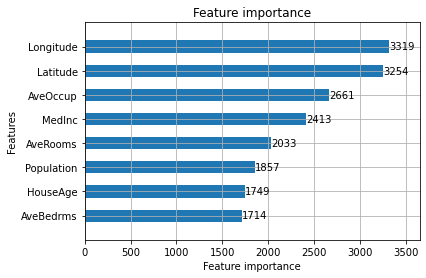

In [6]:
# Display plot of LightGBM feature importances
lgb.plot_importance(lgbr_model, height=.5)

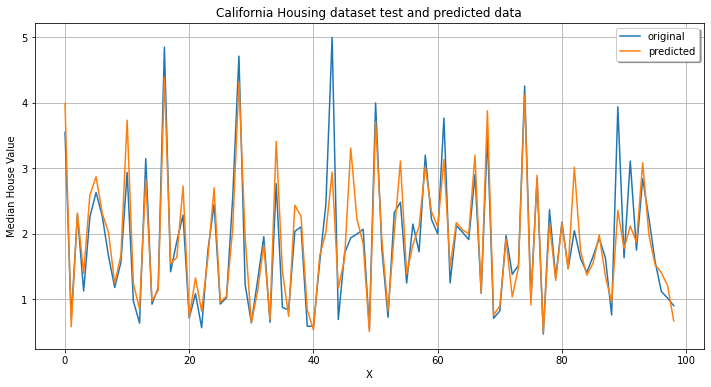

In [7]:
# Display plot of 100 observations vs predicted
num_observations=100
x_ax = range(len(y_test[0:num_observations-1]))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test[0:num_observations-1], label="original")
plt.plot(x_ax, lgbr_preds[0:num_observations-1], label="predicted")
plt.title("California Housing dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Median House Value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [8]:
# Save the model
pickle.dump(lgbr_model, open("lgbr_model.pkl", "wb"))

In [9]:
# load the model
lgbr_model_loaded = pickle.load(open("lgbr_model.pkl", "rb"))

In [11]:
# Sanity Checks to ensure model is the same as before
print("----------------- SANITY CHECKS -----------------")
print("Is the sum of difference between predictions zero?",(lgbr_model.predict(X_test) - lgbr_model_loaded.predict(X_test)).sum() == 0.0)
print("Do the feature importances dictionaries match?",lgbr_feature_importances == lgbr_model_loaded.feature_importances_.tolist())

----------------- SANITY CHECKS -----------------
Is the sum of difference between predictions zero? True
Do the feature importances dictionaries match? True


# Future Improvements
 - Experiment with automated hyperparameter tuning using:
   - FLAML: https://github.com/microsoft/FLAML
   - Optuna: https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258